In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import cvxpy as cvx
from scipy import linalg, sparse
from scipy.optimize import minimize
from typing import Tuple

%matplotlib inline

# Моделирование квантового алгоритма QAOA и его сравнение с классическими алгоритмами

In [2]:
plt.style.use('seaborn')

In [3]:
# Единичная матрица и матрицы Паули 
gate_I = np.eye(2)
gate_X = np.array([[0,1], [1, 0]])
gate_Y = np.array([[0,-1j], [1j, 0]])
gate_Z = np.array([[1,0], [0, -1]])

# гейт Адамара
gate_H = 1/np.sqrt(2)*np.array([[1,1], [1, -1]])

q_0 = np.array([1, 0])
q_1 = np.array([0, 1])

In [4]:
def multikron(lst):
    result = lst[0]
    for i in range(1, len(lst)):
        result = np.kron(result, lst[i])
    return result

In [5]:
def unit(angle, A):
    return sparse.linalg.expm(-(1j)*angle*A)

In [6]:
def construct_C_improved(nodes, edges):
    '''Конструирует гамильтониан по заданному набору вершин и ребер
        
    Параметры
    ==========
    
    nodes - кортеж вершин
    
    edges - кортеж ребер
    
    '''
    gate_I = np.array([1, 1])
    gate_Z = np.array([1, -1])
    C = 1/2*len(edges)*np.array([1]*(2**(len(nodes))))
    for i in range(len(edges)):
        arguments = []
        for j in range(len(nodes)):
            arguments.append(gate_I)
        for j in edges[i]:
            arguments[j] = gate_Z
        C -= 1/2*multikron(arguments)
    return C

In [7]:
def construct_B(n):
    '''Конструирует фукнцию В, которая равняется сумме Х-гейтов,
    действующих на разные биты.
    
    Параметры
    ==========
    
    n - число бит (равняется числу вершин графа)
    
    ''' 
    B = np.zeros((2**n,2**n))
    for i in range(n):
        arguments = []
        for j in range(n):
            arguments.append(gate_I)
        arguments[i] = gate_X
        B += multikron(arguments)
    return B

In [8]:
def exp_B_on_ket(state, angle):
    
    Rotation_operator = linalg.expm((-1j)*angle*gate_X)
    
    q_0_transformed = np.dot(Rotation_operator, q_0)
    q_1_transformed = np.dot(Rotation_operator, q_1)
    

    decomposed_args = []
    z = 0
    result = 0
    for i in range(len(state)):
        s = "{0:b}".format(z)
        while len(s)<int(np.log2(len(state))):
            s = '0' + s
        if s[0]=='0':
            temporary = np.copy(q_0_transformed)
        else:
            temporary = np.copy(q_1_transformed)
        for j in s[1:]:
            if j=='0':
                temporary = np.kron(temporary, q_0_transformed)
            else:
                temporary = np.kron(temporary, q_1_transformed)
        result += state[i]*temporary
        z+=1
    return result

In [10]:
def decomposition(psi):
    '''Раскладывает вектор по вычислительному базису, возвращает коэффициенты
    
    Параметры
    ==========
    
    psi - входное состояние
    
    '''
    coef = []
    for i in range(len(psi)):
        coef.append(np.abs(np.dot(np.eye(len(psi))[i].T, psi))**2)
    return coef
def measure_comp(coef):
    '''Измеряет состояние в вычислительном базисе по заданному состоянию
    
    Параметры
    ==========
    
    psi - входное состояние
    
    '''
    index = 0
    a = coef[index]
    k = np.random.rand()
    while True:
        if k < a:
            result = np.array([np.eye(len(coef))[index]])
            break
        else:
            if index+1<len(coef):
                index+=1
                a+=coef[index]
            else:
                result = np.array([np.eye(len(coef))[index]])
                break 
    return result[0]

In [11]:
def test(Hd, N, coef):
    '''
    Выдает распределение результатов для заданного состония в виде гистограммы.
    Возвращает для максимального найденного разреза:
        битовую строку,
        число ребер в разрезе,
        вероятность получения максимального результата.
    
    Параметры
    ==========
    
    vertices - кортеж вершин
    edges - кортеж ребер
    N - число измерений
    psi - входное состояние
    
    '''
    d = {}
    state = measure_comp(coef)
    max_t = 0
    for i in range(N):
        z = measure_comp(coef)
        t = np.abs(np.dot(np.conj(np.transpose(z)), Hd*z))
        if t > max_t:
            state = z
            max_t = t
        if t not in d.keys():
            d[t] = 1
        else:
            d[t]+=1
    for i in d.keys():
        d[i]/=N
    plt.bar(d.keys(), d.values(), 1)
    return [state, max(list(d.keys())), d[max(list(d.keys()))]]

In [12]:
def bits_string(state):
    '''
    Возвращает битовую строку по заданному состоянию
    
    Параметры
    ==========
    
    state - входное состояние
    
    
    
    '''
    a = 0
    for i in state:
        if i!=1:
            a+=1
        else:
            break
    s = "{0:b}".format(a)
    while len(s)<np.log2(len(state)):
        s = '0' + s
    return s

In [13]:
def color_graph(cut):
    '''
    Раскрашивает вершины графа для удобной визуализации разреза
    
    Параметры
    ==========
    
    cut - битовая строка
    
    '''
    color_map = []
    for i in cut:
        if int(i)==0:
            color_map.append('#1e90ff')
        else: 
            color_map.append('#FFDB58')
    return color_map

## Классический алгоритм

Код взят из этой [статьи](https://arxiv.org/abs/1811.08419)

In [14]:
def goemans_williamson(graph: nx.Graph) -> Tuple[np.ndarray, float, float]:
    """
    The Goemans-Williamson algorithm for solving the maxcut problem.

    Ref:
        Goemans, M.X. and Williamson, D.P., 1995. Improved approximation
        algorithms for maximum cut and satisfiability problems using
        semidefinite programming. Journal of the ACM (JACM), 42(6), 1115-1145
    Returns:
        np.ndarray: Graph coloring (+/-1 for each node)
        float:      The GW score for this cut.
        float:      The GW bound from the SDP relaxation
    """
    # Kudos: Originally implementation by Nick Rubin, with refactoring and
    # cleanup by Jonathon Ward and Gavin E. Crooks
    laplacian = np.array(0.25 * nx.laplacian_matrix(graph).todense())

    # Setup and solve the GW semidefinite programming problem
    psd_mat = cvx.Variable(laplacian.shape, PSD=True)
    obj = cvx.Maximize(cvx.trace(laplacian * psd_mat))
    constraints = [cvx.diag(psd_mat) == 1]  # unit norm
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.CVXOPT)

    evals, evects = np.linalg.eigh(psd_mat.value)
    sdp_vectors = evects.T[evals > float(1.0E-6)].T

    # Bound from the SDP relaxation
    bound = np.trace(laplacian @ psd_mat.value)

    random_vector = np.random.randn(sdp_vectors.shape[1])
    random_vector /= np.linalg.norm(random_vector)
    colors = np.sign([vec @ random_vector for vec in sdp_vectors])
    score = colors @ laplacian @ colors.T

    return colors, score, bound

In [153]:
global_start = time.time()

In [15]:
G = nx.Graph()

In [155]:
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from(((0,1), (1, 2), (2, 3), (0, 3), (0, 2), (1, 3)))

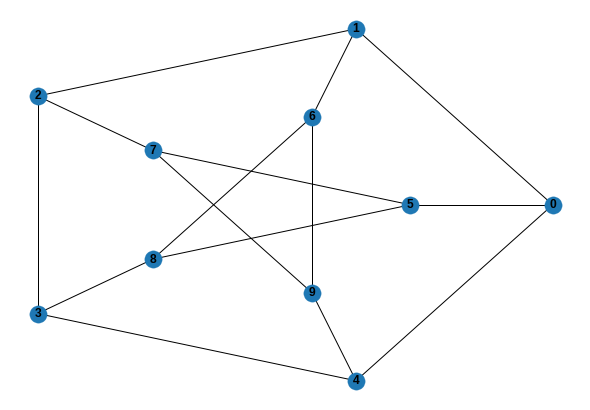

In [16]:
G = nx.petersen_graph()
nodes = sorted(tuple(G.nodes))
edges = tuple(G.edges)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

Найдем разрез с помощью классического алгоритма 

In [157]:
classic_scores = []
for i in range(1000):
    partition, _, bound = goemans_williamson(G)
    classic_scores.append(_)
classic_score = np.mean(classic_scores)
result = max(classic_scores)
proba = classic_scores.count(result)/1000

In [158]:
# Заменим -1 на 0
np.place(partition, partition<0, 0)

Конструируем гамильтониан

In [17]:
hamiltonian = construct_C_improved(nodes, edges)

hamiltonian

array([0., 3., 3., ..., 3., 3., 0.])

In [18]:
full_hamiltonian = np.diag(hamiltonian)

Конструируем оператор B

In [19]:
B = construct_B(len(nodes))

B

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [20]:
maxiter = 50

Зададим сетку углов

In [21]:
gamma = np.arange(0, 2*np.pi, 2*np.pi/5)
beta = np.arange(0, np.pi, np.pi/5)

Чтобы не создавать заново унитарные матрицы в процессе работы алгоритма, определим лист, к которому и будем обращаться

In [22]:
B_unit = [unit(i, B) for i in beta]

In [23]:
C_unit = []
for i in gamma:
    temp = np.zeros(len(hamiltonian), dtype=complex)
    for j in range(len(hamiltonian)):
        temp[j] = np.exp(-(1j)*i*hamiltonian[j])
    C_unit.append(temp)

Определим начальное состояние

In [24]:
init = np.array([1/np.sqrt(2**10)]*1024)

init

array([0.03125, 0.03125, 0.03125, ..., 0.03125, 0.03125, 0.03125])

Максимизируем среднее $F_p = \langle \gamma\beta | \hat{H} | \gamma\beta\rangle$

# p=1

Для начала проведем перебор углов, что не займет много времени, затем используем полученные значения в качестве первого шага оптимизации

In [25]:
F_p = np.zeros((len(gamma), len(beta)))

In [26]:
for i in range(len(gamma)):
    for j in range(len(beta)):
        psi = np.dot(B_unit[j], C_unit[i]*init)
        F_p[i][j] = np.abs(np.dot(np.conj(np.transpose(psi)), hamiltonian*psi))

In [27]:
beta_bru, gamma_bru = np.where(F_p==np.max(F_p))[1][0], np.where(F_p==np.max(F_p))[0][0]

In [28]:
def f_1p(angle):
    temp = [np.exp((-1j)*angle[0]*i) for i in hamiltonian]
    psi = exp_B_on_ket(temp*init, angle[1])
    return -np.abs(np.dot(np.conj(np.transpose(psi)), hamiltonian*psi))

In [29]:
bnds = ((0, 2*np.pi), (0, np.pi))

In [30]:
x0 = [gamma[gamma_bru], beta[beta_bru]]

In [31]:
start = time.time()

res = minimize(f_1p, x0, method='L-BFGS-B',
               options={'gtol': 1e-6, 'disp': True},
               bounds=bnds)

print(res.fun, time.time()-start)

-10.386751345945896 20.579615116119385


In [32]:
res.fun

-10.386751345945896

In [33]:
beta_opt_p_1 = res.x[1]
gamma_opt_p_1 = res.x[0]

In [34]:
beta_opt_p_1, gamma_opt_p_1 

(1.1780971812194818, 3.757071862465302)

In [35]:
psi_res =  np.dot(unit(beta_opt_p_1, B), np.dot(unit(gamma_opt_p_1, np.diag(hamiltonian)), init))

In [36]:
q_score_p_1 = np.abs(np.dot(np.conj(np.transpose(psi_res)), hamiltonian*psi_res))

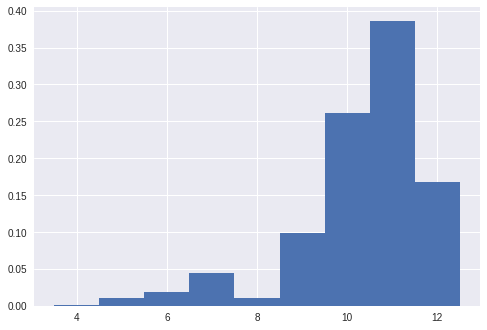

In [37]:
q_partition_p_1, q_result_p_1, q_proba_p_1 = test(hamiltonian, 1000, decomposition(psi_res))

In [38]:
q_partition_p_1

array([0., 0., 0., ..., 0., 0., 0.])

# p=2

In [39]:
F_p = np.zeros((len(gamma), len(beta), len(gamma), len(beta)))

for i in range(len(gamma)):
    for j in range(len(beta)):
        for m in range(len(gamma)):
            for k in range(len(beta)):
                temp = C_unit[i]*init
                temp = np.dot(B_unit[j], temp)
                temp = C_unit[m]*temp
                psi = np.dot(B_unit[k], temp)
                F_p[i][j][m][k] = np.abs(np.dot(np.conj(np.transpose(psi)), hamiltonian*psi))

In [40]:
x0 = []
for i, j in enumerate(np.where(F_p==np.max(F_p))):
    if i%2==0:
        x0.append(gamma[j[0]])
    else:
        x0.append(beta[j[0]])

In [41]:
def f_2p(angle):
    
    C_psi = [np.exp((-1j)*angle[0]*i) for i in hamiltonian]
    psi = exp_B_on_ket(C_psi*init, angle[1])
    
    temp = [np.exp((-1j)*angle[2]*i) for i in hamiltonian]
    psi = exp_B_on_ket(temp*psi, angle[3])
    
    return -np.abs(np.dot(np.conj(psi), hamiltonian*psi))

In [42]:
bnds = ((0, 2*np.pi), (0, np.pi), (0, 2*np.pi), (0, np.pi))
start = time.time()

res = minimize(f_2p, x0, method='L-BFGS-B',
               options={'gtol': 1e-6, 'disp': True},
               bounds=bnds)

print(res.fun, time.time()-start)

-10.936384543101974 137.38950896263123


In [43]:
res.x

array([3.80728373, 1.33469538, 4.93853531, 1.81374681])

In [44]:
beta_opt_p_2 = []
gamma_opt_p_2 = []
for i, j in enumerate(res.x):
    if i%2==0:
        gamma_opt_p_2.append(j)
    else:
        beta_opt_p_2.append(j)
beta_opt_p_2 = np.array(beta_opt_p_2)
gamma_opt_p_2 = np.array(gamma_opt_p_2)

In [45]:
res.x[3], res.x[2], res.x[1], res.x[0]

(1.8137468104900074, 4.938535314611953, 1.3346953820695795, 3.807283732038734)

In [46]:
psi_res =  np.dot(unit(res.x[3], B), np.dot(unit(res.x[2], np.diag(hamiltonian)), np.dot(unit(res.x[1], B), 
                 np.dot(unit(res.x[0], np.diag(hamiltonian)), init))))

In [55]:
print(('%.3f + %.3f * I') % (np.real(psi_res[0]), np.imag(psi_res[0])))

-0.001 + 0.002 * I


In [67]:
len(psi_res)

1024

In [69]:
f = open("my_state.csv", "w")
f.write('real, imag\n')
j = 0
for i in psi_res:
    j+=1
    f.write(('%f,%f\n') % (np.real(i), np.imag(i)))
print(j)

1024


In [189]:
q_score_p_2 = np.abs(np.dot(np.conj(psi_res), hamiltonian*psi_res))

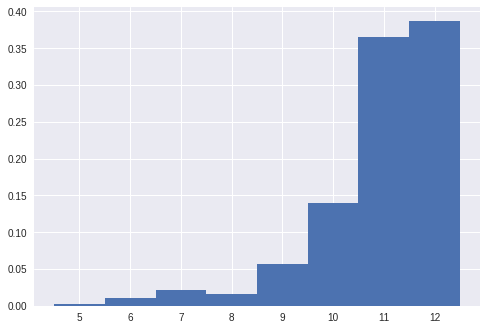

In [190]:
q_partition_p_2, q_result_p_2, q_proba_p_2 = test(hamiltonian, 1000, decomposition(psi_res))

# p=3

In [191]:
F_p = np.zeros((len(gamma), len(beta), len(gamma), len(beta), len(gamma), len(beta)))

for i in range(len(gamma)):
    for j in range(len(beta)):
        for m in range(len(gamma)):
            for k in range(len(beta)):
                for p in range(len(gamma)):
                    for q in range(len(beta)):
                        temp = C_unit[i]*init
                        temp = np.dot(B_unit[j], temp)
                        temp = C_unit[m]*temp
                        temp = np.dot(B_unit[k], temp)
                        temp = C_unit[p]*temp
                        psi = np.dot(B_unit[q], temp)
                        F_p[i][j][m][k][p][q] = np.abs(np.dot(np.conj(np.transpose(psi)), hamiltonian*psi))

In [192]:
np.where(F_p==np.max(F_p))

(array([2]), array([1]), array([2]), array([2]), array([3]), array([2]))

In [193]:
x0 = []
for i, j in enumerate(np.where(F_p==np.max(F_p))):
    if i%2==0:
        x0.append(gamma[j[0]])
    else:
        x0.append(beta[j[0]])

In [194]:
np.max(F_p)

10.736457998224601

In [195]:
def f_3p(angle):
    
    C_psi = [np.exp((-1j)*angle[0]*i) for i in hamiltonian]

    psi = exp_B_on_ket(C_psi*init, angle[1])
    
    temp = [np.exp((-1j)*angle[2]*i) for i in hamiltonian]

    psi = exp_B_on_ket(temp*psi, angle[3])
    
    C_psi = [np.exp((-1j)*angle[4]*i) for i in hamiltonian]
    psi = exp_B_on_ket(C_psi*psi, angle[5])
    
    return -np.abs(np.dot(np.conj(psi), hamiltonian*psi))

In [ ]:
s = time.time()

bnds = ((0, 2*np.pi), (0, np.pi), (0, 2*np.pi), (0, np.pi), (0, 2*np.pi), (0, np.pi))
res = minimize(f_3p, x0, method='L-BFGS-B',
               options={'gtol': 1e-6, 'disp': True},
               bounds=bnds)

print(res.fun, time.time()-s)

In [ ]:
beta_opt_p_3 = np.zeros(3)
gamma_opt_p_3 = np.zeros(3)

In [ ]:
beta_opt_p_3 = []
gamma_opt_p_3 = []
for i, j in enumerate(res.x):
    if i%2==0:
        gamma_opt_p_3.append(j)
    else:
        beta_opt_p_3.append(j)
beta_opt_p_3 = np.array(beta_opt_p_3)
gamma_opt_p_3 = np.array(gamma_opt_p_3)

In [ ]:
psi_res =  np.dot(unit(res.x[5], B),
                  np.dot(unit(res.x[4], np.diag(hamiltonian)), 
                  np.dot(unit(res.x[3], B), 
                         np.dot(unit(res.x[2], np.diag(hamiltonian)), 
                                np.dot(unit(res.x[1], B), 
                                     np.dot(unit(res.x[0], np.diag(hamiltonian)), init))))))

In [ ]:
q_score_p_3 = np.abs(np.dot(np.conj(psi_res), hamiltonian*psi_res))

In [ ]:
q_partition_p_3, q_result_p_3, q_proba_p_3 = test(hamiltonian, 1000, decomposition(psi_res))

In [ ]:
t = time.time()-global_start

In [ ]:
m = t//60
s = t - (t//60)*60
print('Время работы программы %d минут %d секунд' % (m, s))

In [ ]:
fig  =  plt.figure(1)
ax   = fig.add_subplot(111)
plt.minorticks_on()
ax.axvline(1, color='white', lw=1)
ax.axvline(2, color='white', lw=1)
ax.axvline(3, color='white', lw=1)
plt.scatter([1, 2, 3], [q_score_p_1/12, q_score_p_2/12, q_score_p_3/12], label='QAOA', s=65)
#plt.axis([0, 4, 8, 14])
ax.axhline(classic_score/12, color='yellow', label='Goemans-Williamson')
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5')
plt.grid(which = 'minor', linestyle = '-', linewidth = '0.2')
plt.xlabel(u'$p$', fontsize=20)
plt.ylabel(u'$Mean\;\;\;Ratio$', fontsize=20)
plt.tight_layout() 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
plt.xticks([1, 2, 3])
legend = ax.legend(loc='upper left',frameon='True', fontsize='19') #bbox_to_anchor=(1.55, 1, 0, 0)
legend.get_frame().set_facecolor('#FFFFFF')
plt.savefig('ResultPG', dpi=1200, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

In [ ]:
fig  =  plt.figure(1)
ax   = fig.add_subplot(111)
plt.minorticks_on()
plt.scatter([1, 2, 3], [q_proba_p_1, q_proba_p_2, q_proba_p_3], label='probability')
plt.axis([0, 4, 0, 1])
ax.axhline(proba, color='yellow', label='classic score')
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5')
plt.grid(which = 'minor', linestyle = '-', linewidth = '0.2')
plt.xlabel(u'$p$', fontsize=15)
plt.ylabel(u'$Scores$', fontsize=15)
plt.tight_layout()
legend = ax.legend(loc='best',frameon='True', fontsize='x-large')
legend.get_frame().set_facecolor('#FFFFFF')
plt.show()

In [ ]:
fig  =  plt.figure(1)
ax   = fig.add_subplot(111)
plt.minorticks_on()
plt.scatter([1, 2, 3], [gamma_opt_p_1, gamma_opt_p_2[0], gamma_opt_p_3[0]], label='probability')
plt.scatter([2, 3], [gamma_opt_p_2[1], gamma_opt_p_3[1]])
plt.scatter([3], [gamma_opt_p_3[2]])
ax.axhline(proba, color='yellow', label='classic score')
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5')
plt.grid(which = 'minor', linestyle = '-', linewidth = '0.2')
plt.xlabel(u'$p$', fontsize=15)
plt.ylabel(u'$Scores$', fontsize=15)
plt.tight_layout()
legend = ax.legend(loc='best',frameon='True', fontsize='x-large')
legend.get_frame().set_facecolor('#FFFFFF')
plt.show()

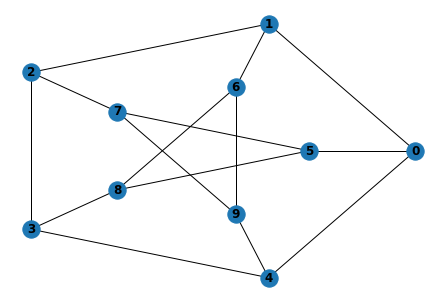

In [3]:
G = nx.petersen_graph()
nodes = sorted(tuple(G.nodes))
edges = tuple(G.edges)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [4]:
nodes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
print('{', end='')
for i in edges:
    print('{%d, %d},' % (i[0], i[1]), end = ' ')
print('}')

{{0, 1}, {0, 4}, {0, 5}, {1, 2}, {1, 6}, {2, 3}, {2, 7}, {3, 4}, {3, 8}, {4, 9}, {5, 7}, {5, 8}, {6, 8}, {6, 9}, {7, 9}, }


In [ ]:
tuple(nx.complete_graph(25).edges)